
## <span style='background :lightgreen' > In this jupyter notebook, the seasonal T, ET, REF, NPP are calculated using data from the FAO portal to monitor Water Productivity through Open access of Remotely sensed derived data (WaPOR)
Methodology documents on data used (WaPOR): http://www.fao.org/3/i8225en/I8225EN.pdf#page=17&zoom=100,92,97
![Fig2.png](attachment:../Data/img/Fig2.png)
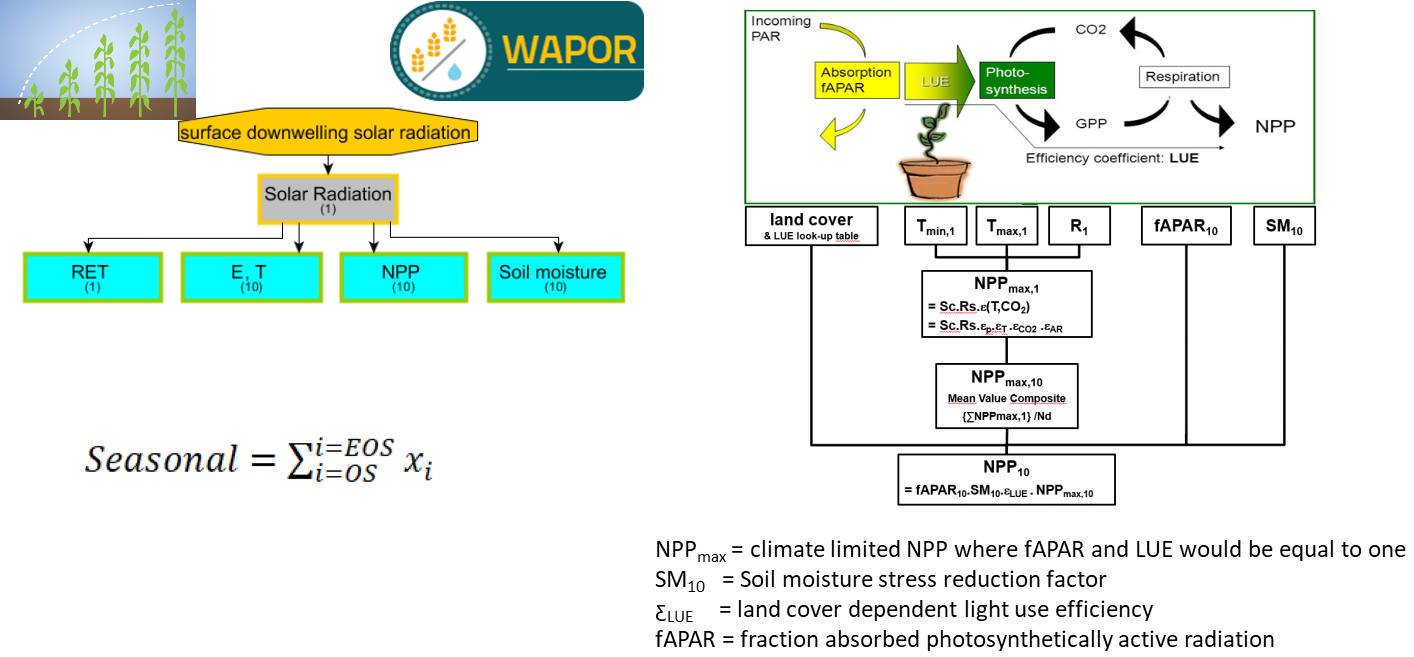

## <font color='green'>1 Import modules/libraries</font>

In [1]:
import os                                 #a module for interacting with the operating system
import sys
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "Modules")) # change the directory to where the modules are saved
import WaPOR                              # API to interact with WaPOR portal
from GIS_functions import GIS_function as gis
import glob                               #used to retrieve files/pathnames matching a specified pattern
import pandas as pd                       #to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import re                                 #re sub() module can be used to replace substring
from matplotlib import pyplot as plt      #is a plotting library used for 2D graphics in python 

#Get personaL WAPOR API Token by registering in the top right cornor of the page: wapor.apps.fao.org/home/1
#WAPOR API Token= 89bb4904914c62f2878ab36b35884ca391eb3c2c1795dba38537dff2e012b3a091b56fdea7236f44

Insert WAPOR API Token: 89bb4904914c62f2878ab36b35884ca391eb3c2c1795dba38537dff2e012b3a091b56fdea7236f44


# <font color='#ff009a'>2 Calculate seasonal T, ET, REF, NPP</font>
#Tranpiration (T), actual evapotranpiration and interception (AETI), reference evapotranpiration (REF) and net primary production (NPP)

## <font color='blue'>a) Import the input data (T, AETI, REF, NPP)</font>

In [12]:
dir_proj = os.path.split(os.getcwd())[0]  
dir_data = "Data"

# transpiration, evapotranpiration & interceptio and reference evapotranspiration
input_folderT = os.path.join(dir_proj, dir_data, "1L2_T_D") 
input_fhsT=glob.glob(input_folderT+'\*.tif')                   # glob.glob returns the list of files with their full path

input_folderET = os.path.join(dir_proj, dir_data, "1L2_AETI_D") 
input_fhsET=glob.glob(input_folderET+'\*.tif')   

input_folderRET = os.path.join(dir_proj, dir_data, "1L1_RET_D_resampled") 
input_fhsRET=glob.glob(input_folderRET+'\*.tif')

input_folderNPP = os.path.join(dir_proj, dir_data, "1L2_NPP_D") 
input_fhsNPP=glob.glob(input_folderNPP+'\*.tif')

# Masks: landcover layers and the shape of the project area
input_LCCfolder = os.path.join(dir_proj, dir_data, "1L2_LCC_A") 
LCC_tifs        = glob.glob(input_LCCfolder+'\*.tif')
ProArea =gis.OpenAsArray(r'..\Data\1ShapeTif\mask_irrigation_types.tif',nan_values=True) #he project area (tif)

## <font color='blue'>b) Identify the time of the raster (cube code)</font>
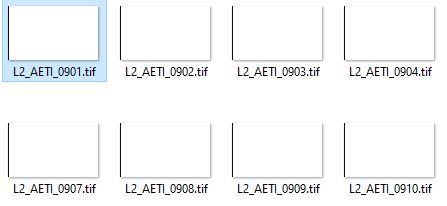 
<br/> #-------------------------------------------------------------------------------
* Running the following script takes longtime
* The codes run one time, only if the latest date in the 'time_range' is updated.
* This section requires internet and takes longtime. 
* While running this section for the first time, the the catalog info is saved in the working directory.
* Running for the second time or so should skip this and run the next one (# read the df_avial from already saved excel) 
<br/>#--------------------------------------------------------------------------------

In [16]:
# read the cube info (dataframe) from the cataloge 
WaPOR.API.version=2
cube_codeT   = 'L2_T_D' 
cube_codeET  = 'L2_AETI_D' 
cube_codeRET = 'L1_RET_D' 
cube_codeNPP = 'L2_NPP_D' 

time_range   = '2009-01-01,2019-12-31'

df_availT   = WaPOR.API.getAvailData(cube_codeT, time_range)
df_availET  = WaPOR.API.getAvailData(cube_codeET, time_range)
df_availRET = WaPOR.API.getAvailData(cube_codeRET, time_range)
df_availNPP = WaPOR.API.getAvailData(cube_codeNPP, time_range)

# save the dataframe to excel to access it offline
output_folder = os.path.join(os.path.split(os.getcwd())[0], "Data") 

df_availT.to_excel(os.path.join(output_folder, 'df_availT.xlsx'))
df_availET.to_excel(os.path.join(output_folder, 'df_availET.xlsx'))
df_availRET.to_excel(os.path.join(output_folder, 'df_availRET.xlsx'))
df_availNPP.to_excel(os.path.join(output_folder, 'df_availNPP.xlsx'))

Loading WaPOR catalog...


In [17]:
# read the df_avial from already saved excel 

time_range   = '2009-01-01,2019-12-31'

df_availT   = pd.read_excel('../data/df_availT.xlsx')
df_availET  = pd.read_excel('../data/df_availET.xlsx')
df_availRET = pd.read_excel('../data/df_availRET.xlsx')
df_availNPP = pd.read_excel('../data/df_availNPP.xlsx')

## <font color='blue'>c) Make or connect with the directory the output folder</font>

In [18]:
# the directory of the output folder
dir_proj = os.path.split(os.getcwd())[0]  
dir_data = "Data"
output_folderT   = os.path.join(dir_proj, dir_data, "2L2_T_season") 
output_folderET  = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
output_folderRET = os.path.join(dir_proj, dir_data, "2L1_RET_season") 
output_folderNPP = os.path.join(dir_proj, dir_data, "2L2_NPP_season") 

# Make one if the folder does not exit
if not os.path.exists(output_folderT):
    os.makedirs(output_folderT) 
if not os.path.exists(output_folderET):
    os.makedirs(output_folderET) 
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET) 
if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP) 

## <font color='blue'>d) Define function to add the rasters from start to end of seasons</font>
#This function calculate the seasonal value given rasters at dekadal time intervanl

In [19]:
# summation of raster between two dates
def SumSeason(input_fhs, saveSum, sowing_date, harvesting_date, ProArea, df_avail, LCC):
    """
    Add raster files (input_fhs) between sowing_date and harvesting_date.
    
    Parameters
    ----------
    input_fhs : raster file
        Files to be added.
    saveSum : folder name
        Folder name where the sum to be saved.
    sowing_date : date in yyyy-mm-dd format
        Starting date of crop growth.
    harvesting_date : date in yyyy-mm-dd format
        Harvesting date of crop.
    ProArea : tiff file
        Folder holding the boundary of the crop land.
    df_avail : cube_code of the raster
        Helps to read the date of each raster file.
    LCC : Land cover tiff files
        Helps to select irrigated/rainfed land classes.
    Returns
    -------
    Sums: array
        Seasonal, sum of the raster files.
    """
    period_dates=pd.date_range(sowing_date,harvesting_date,freq='D') #generate dates b/n sowing and harvesting dates
    period_fhs=[]
    # collect the rasters if they are within sowing and harvesting date
    for in_fh in input_fhs:
        #get raster id from file name
        raster_id=os.path.split(in_fh)[-1].split('.')[0]               
        #get raster info using raster id
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]     # the time_code corresponding to raster id
        #get start and end date of raster
        raster_startdate=raster_info['time_code'].iloc[0].split(',')[0] # [2009-01-01
        raster_startdate=re.sub(r"[[)]","", raster_startdate)           # replace [) with nothing(delete)
        raster_enddate=raster_info['time_code'].iloc[0].split(',')[-1]  # 2009-01-11)
        raster_enddate=re.sub(r"[[)]","", raster_enddate)               
        #check if raster belong to period
        if ((raster_startdate in period_dates) or (raster_enddate in period_dates)):
            period_fhs.append(in_fh)

    # add the layers between the sowing and harvesting dates
    period_fhs
    period_fh=period_fhs[0]
    Sums=0
    for period_fh in period_fhs:
        Sum=gis.OpenAsArray(period_fh, nan_values=True)
        Sums+=Sum
       
    # maskout non crop 
    Lcc=gis.OpenAsArray(LCC, nan_values=True)
    Sums=np.where((Lcc==42) & (ProArea<=3),Sums,np.nan)
    
    # save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh=os.path.join(saveSum,raster_id.split('_')[1]+'_'+str(sowing_date)+'_to_'+str(harvesting_date)+'.tif')        
    gis.CreateGeoTiff(out_fh,Sums,driver,NDV,xsize,ysize,GeoT,Projection) ### Save the array 'Sums' as raster
        
    return Sums  

## <font color='blue'>e) Define the Start Of crop Season (SOS) and End Of crop Season (EOS)</font>
* Edit the start and end of crop seasons in the df_SOsEos.xlsx file in the data folder
* The start and end of crop seasons are identical for a season and raster file

In [21]:
df_dates   = pd.read_excel('../data/df_SosEos.xlsx')
df_dates

,Seasons,SOS,EOS
0,1,2009-10-01,2010-09-30
1,2,2010-10-01,2011-09-30
2,3,2011-10-01,2012-09-30
3,4,2012-10-01,2013-09-30
4,5,2013-10-01,2014-09-30
5,6,2014-10-01,2015-09-30
6,7,2015-10-01,2016-09-30
7,8,2016-10-01,2017-09-30
8,9,2017-10-01,2018-09-30
9,10,2018-10-01,2019-09-30


### <font color='#ff009a'>2.i) Calculate seasonal transpiration (T)

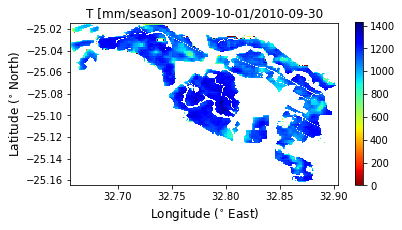

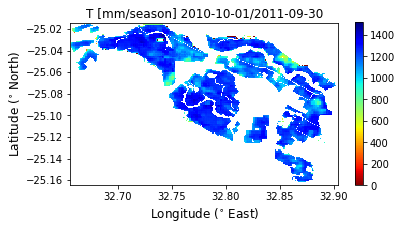

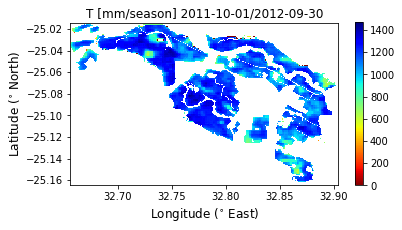

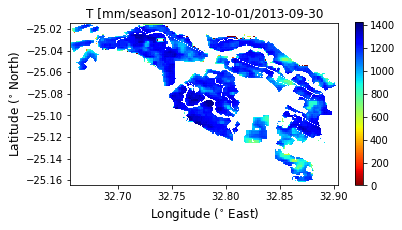

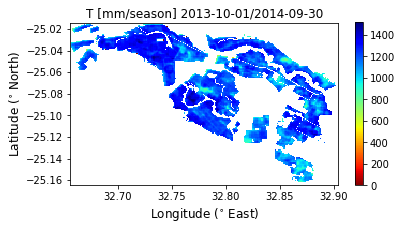

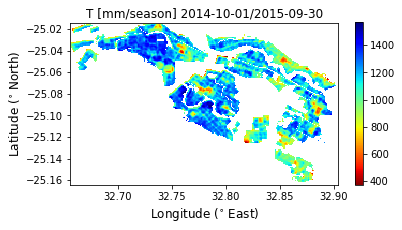

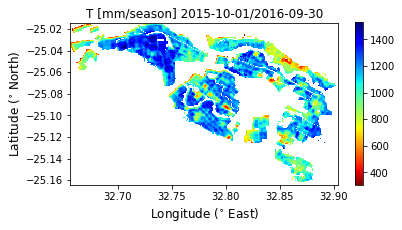

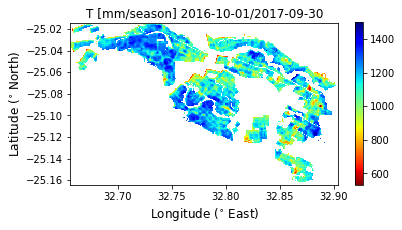

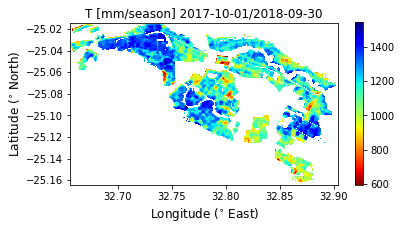

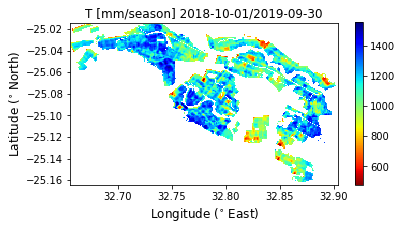

In [22]:
# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhsT[0]  

driver,NDV,xsize,ysize,GeoT,Projection=gis.GetGeoInfo(in_fh)
spatial_extent=(GeoT[0],GeoT[0]+GeoT[1]*xsize,GeoT[3]+GeoT[5]*ysize,GeoT[3]) #get spatial extent of raster

length = len(df_dates)  #length of season

i=0
while i<length:
    # calculate the seasonal value and save in output_folderT
    seasonal = SumSeason(input_fhsT, output_folderT, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availT,  LCC=LCC_tifs[i])

    # Plot the raster map
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75)
    plt.xlabel('Longitude ($^{\circ}$ East)',fontsize=12) #add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)',fontsize=12)
    plt.title('T [mm/season] '+str(df_dates.SOS[i].date())+'/'+str(df_dates.EOS[i].date()))
    plt.show ()   
    i+=1

### <font color='#ff009a'>2.ii) Calculate seasonal evapotratranspiration

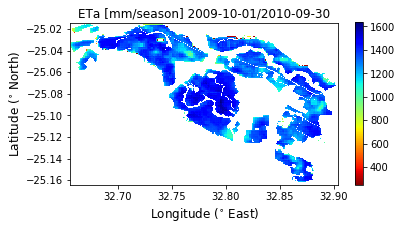

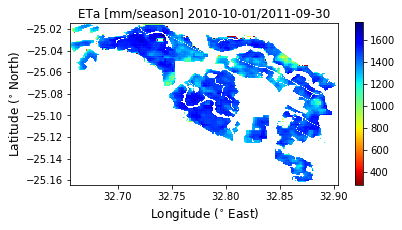

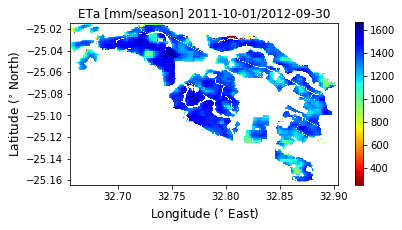

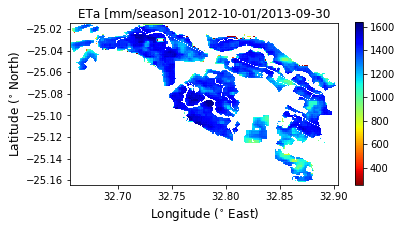

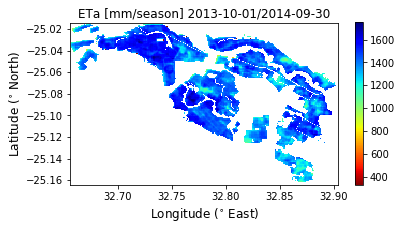

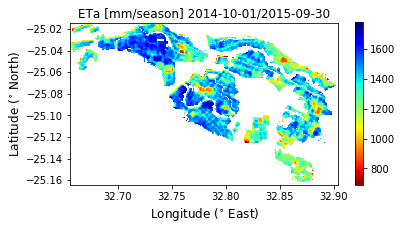

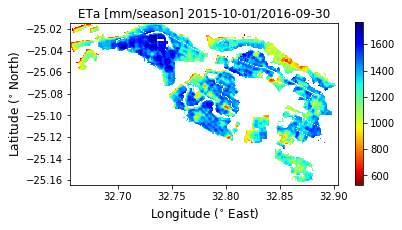

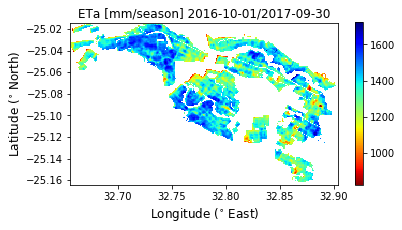

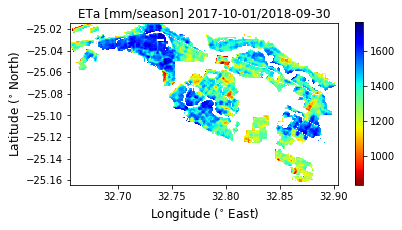

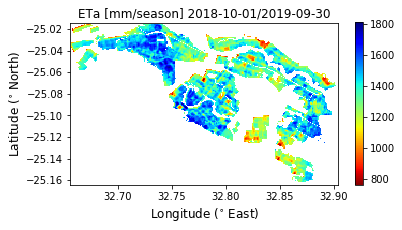

In [23]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]    

driver,NDV,xsize,ysize,GeoT,Projection=gis.GetGeoInfo(in_fh)
spatial_extent=(GeoT[0],GeoT[0]+GeoT[1]*xsize,GeoT[3]+GeoT[5]*ysize,GeoT[3]) #get spatial extent of raster

length = len(df_dates)  #length of seasonn
                
i=0
while i<length:
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsET, output_folderET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availET,  LCC=LCC_tifs[i])

    # Plot the raster map
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75)
    plt.xlabel('Longitude ($^{\circ}$ East)',fontsize=12) #add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)',fontsize=12)
    plt.title('ETa [mm/season] '+str(df_dates.SOS[i].date())+'/'+str(df_dates.EOS[i].date()))
    plt.show ()   
    i+=1

### <font color='#ff009a'>2.iii) Calculate seasonal Reference Evapotranpiration(RET)

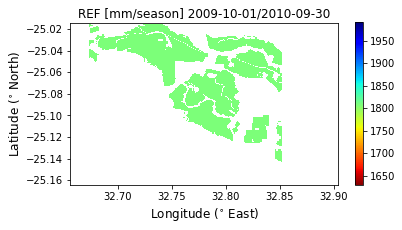

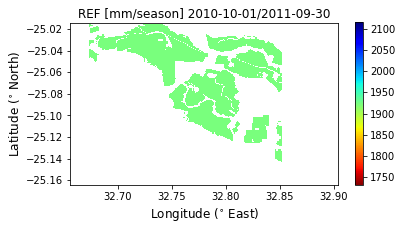

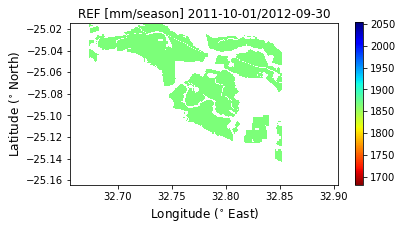

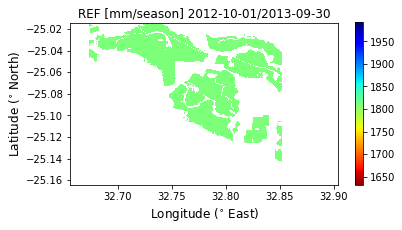

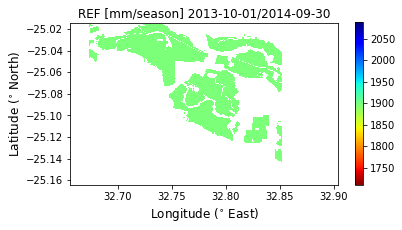

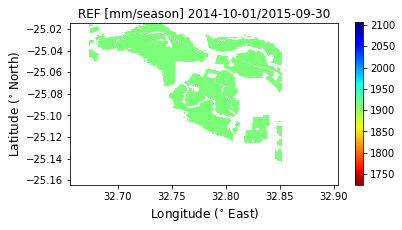

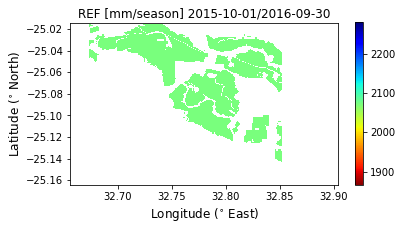

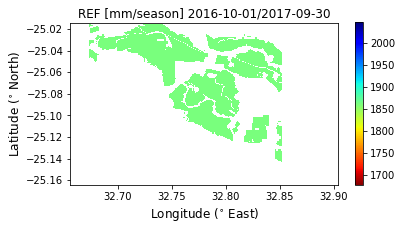

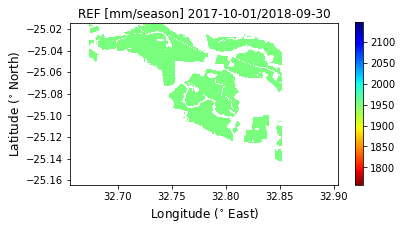

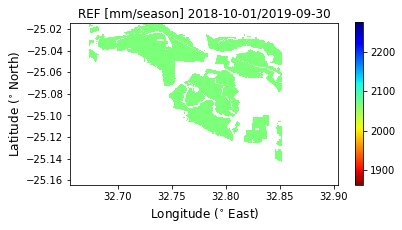

In [24]:
# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhsRET[0]       ###
driver,NDV,xsize,ysize,GeoT,Projection=gis.GetGeoInfo(in_fh)
spatial_extent=(GeoT[0],GeoT[0]+GeoT[1]*xsize,GeoT[3]+GeoT[5]*ysize,GeoT[3]) #get spatial extent of raster

length = len(df_dates)  #length of season

i=0
while i<length:
    # 
    seasonal = SumSeason(input_fhsRET, output_folderRET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availRET,  LCC=LCC_tifs[i])

    # Plot the raster map
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75)
    plt.xlabel('Longitude ($^{\circ}$ East)',fontsize=12) #add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)',fontsize=12)
    plt.title('REF [mm/season] '+str(df_dates.SOS[i].date())+'/'+str(df_dates.EOS[i].date()))
    plt.show ()   
    i+=1

### <font color='#ff009a'>2.iv) Calculate seasonal Net Primary Production (NPP)

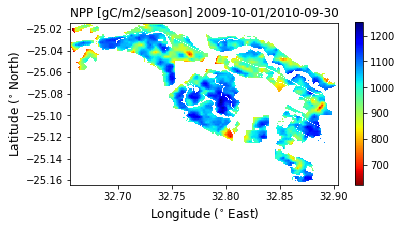

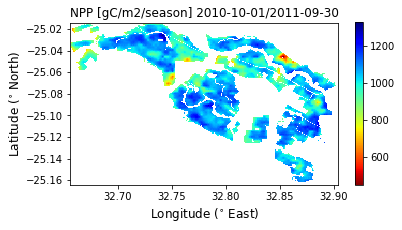

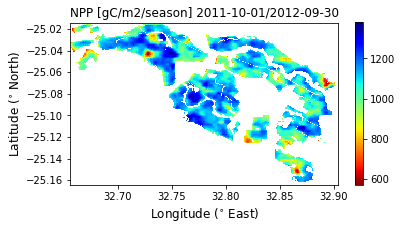

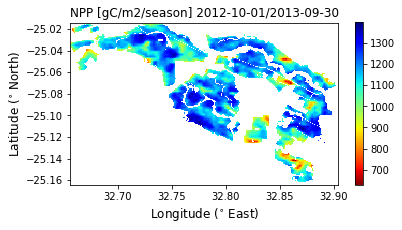

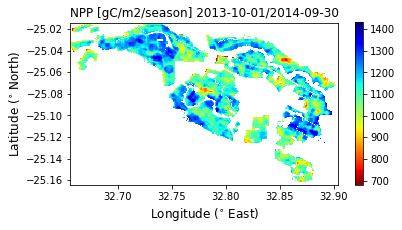

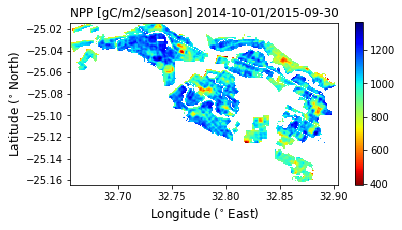

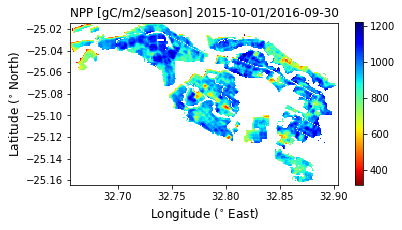

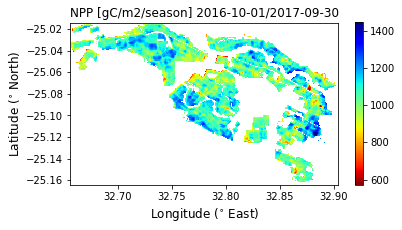

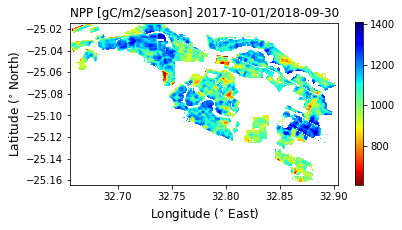

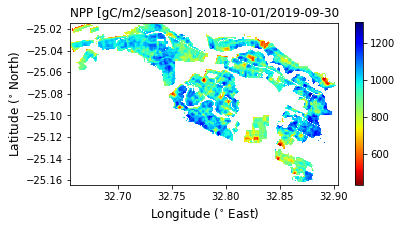

In [25]:
# collecting Geoinfo such as projection, the x and y axis
in_fh=input_fhsNPP[0]       ###

driver,NDV,xsize,ysize,GeoT,Projection=gis.GetGeoInfo(in_fh)
spatial_extent=(GeoT[0],GeoT[0]+GeoT[1]*xsize,GeoT[3]+GeoT[5]*ysize,GeoT[3]) #get spatial extent of raster

length = len(df_dates)  #length of season

i=0
while i<length:
    # 
    seasonal = SumSeason(input_fhsNPP, output_folderNPP, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availNPP,  LCC=LCC_tifs[i])

    # Plot the raster map
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75)
    plt.xlabel('Longitude ($^{\circ}$ East)',fontsize=12) #add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)',fontsize=12)
    plt.title('NPP [gC/m2/season] '+str(df_dates.SOS[i].date())+'/'+str(df_dates.EOS[i].date()))
    plt.show ()   
    i+=1
    

# Exercise 
## Calculate seasonal T, ET, RET and NPP for your project area 